# Implementation of the Monte Carlo Simulation of Zhang et al. (2005)

### Importation of the required packages

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from math import exp, log, sqrt, pi
import time
import pandas as pd
from sklearn.neighbors import KernelDensity

### Monte Carlo Simulation of the Heston Model

In [2]:
##############################################   Parameters Values     ##############################################
numPaths = 10000 #We simulated 10,000 paths
rho = -0.5        # correlation of the bivariables
S_0 = 100             # initil asset price
V_0 = 0.04      # initial variance
kappa = 5       # mean-reversion rate 
theta = 0.04    # long-run variance
sigma = 0.5        # volatility of volatility
r = 0.5            # expected return
dt = 1/(252*(6.5)*60*60)# size of time-step which corresponds here to the number of seconds in a year
Tmax = 1/(252) #Corresponds to one day 
chosen_std=0.0005 #This corresponds to the standard deviation given in Zhang et al. (2005) paper
######################################################################################################################


In [3]:
start = time.time()


# simulate the asset paths under Heston model 
num_time = round(Tmax/dt) #Number of seconds in one day 
    
#Will use the logarithmic price to enhance the performance of the algorithm
log_S = np.zeros((num_time+1, numPaths)) #We generate a matrix that will store in each column a realization of the log price
#S=True price + noise
log_true_price = np.zeros((num_time+1, numPaths)) #We generate a matrix that will store in each column the true price
log_S[0,:] = log(S_0) #We initialize the initial price 
log_true_price[0,:]=log(S_0)
V = np.zeros((num_time+1, numPaths))#We generate a matrix that will store in each column a realization of the variance
error_term=chosen_std*np.random.normal(0, 1, (num_time+1, numPaths)) #We simulate a noise term with standard deviation
#given by the chosen_std and of mean 0 

V[0,:] = V_0 #We initialize the initial variance 

Vcount0 = 0 #This variable will count the number of 0 variances in the monte carlo simulation 
for i in range(numPaths):
    Zv = np.random.randn(num_time+1)*sqrt(dt) 
    Zs = rho*Zv + sqrt(1-rho**2)*sqrt(dt)*np.random.randn(num_time+1)
    # the 2 stochastic drivers for variance V and asset price S         

    for t_step in range(1, num_time+1): 
        
         # We use Euler discretization scheme at a time interval Δt=1 second to discretize the Heston SDEs

        V[t_step,i] =  V[t_step-1,i] + kappa*(theta-V[t_step-1,i])*dt+ sigma* sqrt(V[t_step-1,i])* Zv[t_step] 
        if V[t_step,i] <= 0:
                Vcount0 = Vcount0+1
                V[t_step,i] = abs(V[t_step,i]) #We use the reflection principle if the variance is negative
       

        log_S[t_step,i] = log_S[t_step-1,i] + (r-(V[t_step-1,i]/2))*dt + sqrt(V[t_step-1,i])*Zs[t_step] 
        
    
    log_true_price[:,i]=log_S[:,i] #This is the log of latent price X
    log_S[:,i]=log_S[:,i] + error_term[:,i]#We make sure to add the noise to get the observable price
    #The noise needs to be iid that is the reason why we need to add it after the simulation 

S=np.exp(log_S)
X=np.exp(log_true_price)
end = time.time()
print("Time taken to run the Monte Carlo Simulation: ", end - start,"sec")


Time taken to run the Monte Carlo Simulation:  1642.7202429771423 sec


In [4]:
Vcount0 #No negative variance among our simulation

0

### Sample paths of the simulated true price and variance

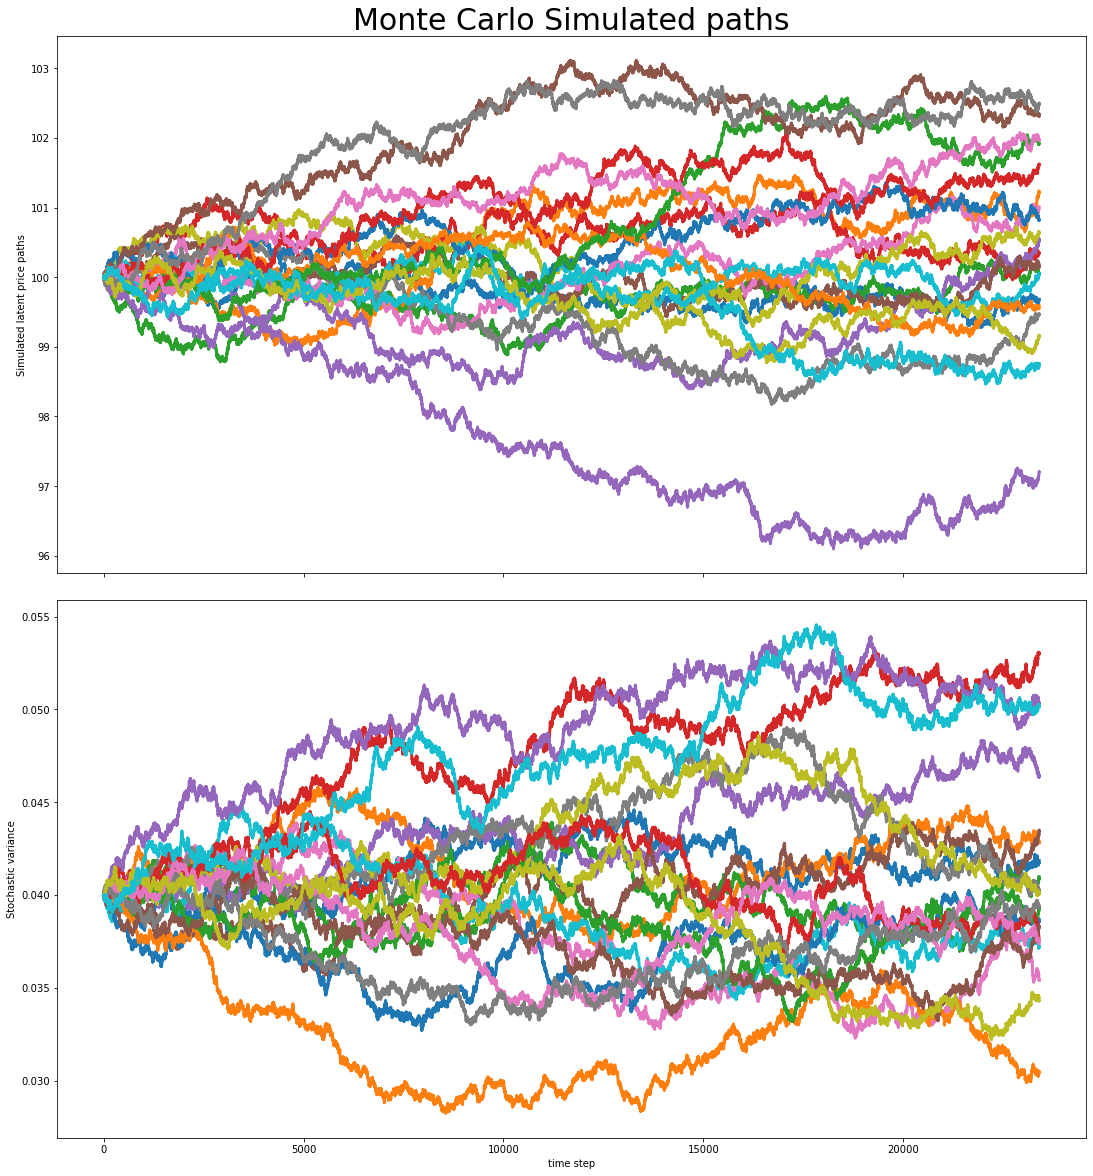

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.set_title('Monte Carlo Simulated paths', fontsize=30)

fig.tight_layout()

ax1.plot(X[:,0:20],linewidth=3)
ax1.set(ylabel="Simulated latent price paths")

ax2.plot(V[:,0:20],linewidth=3)
ax2.set(ylabel="Stochastic variance")
plt.rcParams.update({'font.size': 25})


plt.xlabel('time step')
fig.set_figheight(20)
fig.set_figwidth(20)
plt.subplots_adjust(wspace=0, hspace=0.05)
plt.show()


### Sample paths of the observable price and variance

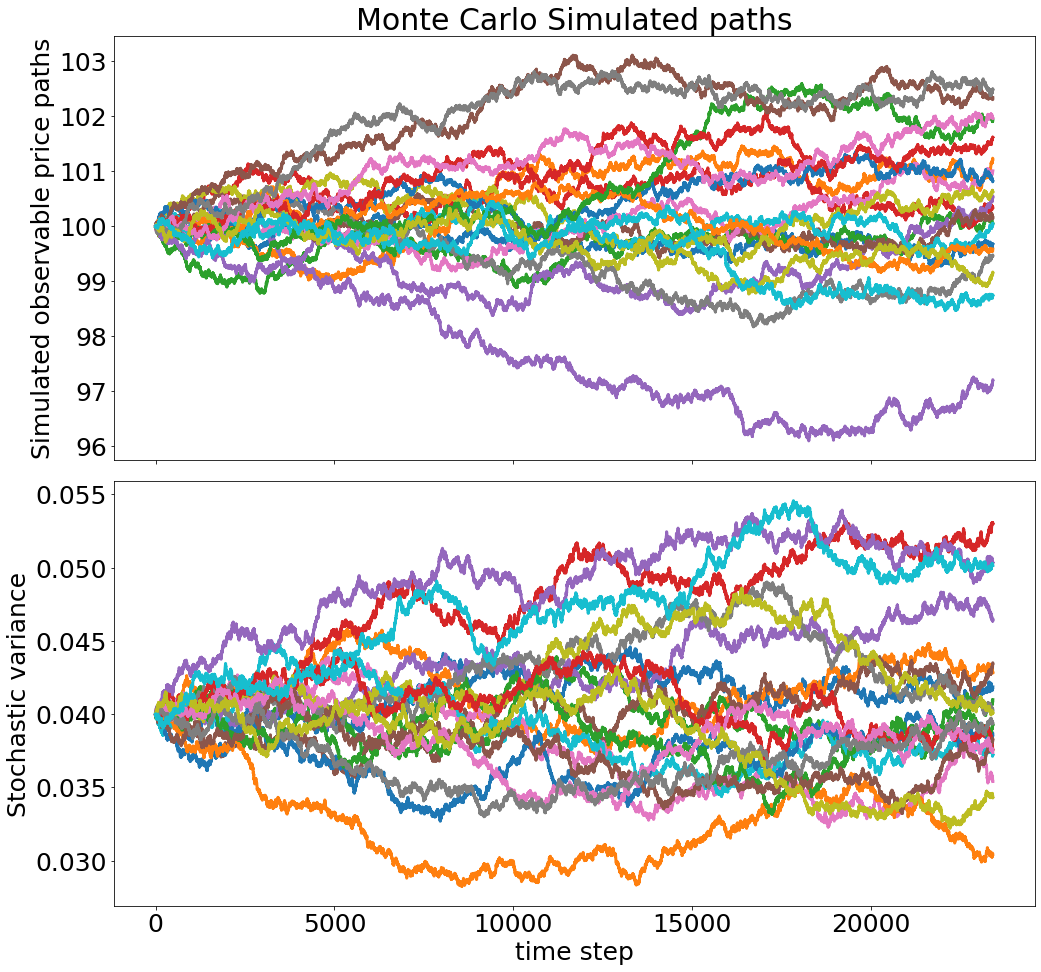

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.set_title('Monte Carlo Simulated paths', fontsize=30)

fig.tight_layout()

ax1.plot(X[:,0:20],linewidth=3)
ax1.set(ylabel="Simulated observable price paths")

ax2.plot(V[:,0:20],linewidth=3)
ax2.set(ylabel="Stochastic variance")
plt.rcParams.update({'font.size': 25})


plt.xlabel('time step')
fig.set_figheight(20)
fig.set_figwidth(20)
plt.subplots_adjust(wspace=0, hspace=0.05)
plt.show()


### Sample paths of simulated error terms


Text(0.5, 0, 'time step')

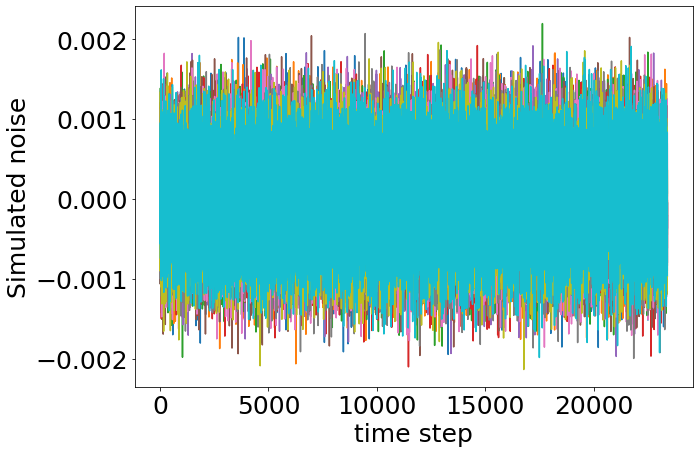

In [7]:
fig = plt.figure(figsize=(10, 7))
plt.plot(error_term[:,0:10])
plt.ylabel('Simulated noise')
plt.xlabel('time step')

#This is the noise that we added

## Implementation of the indicators

In [8]:
S=pd.DataFrame(S)
V=pd.DataFrame(V)

In [ ]:
returns=np.log(S / S.shift())
returns=returns.iloc[1:]

In [ ]:
log_S=pd.DataFrame(log_S)
returns=log_S-log_S.shift()
returns=returns.iloc[1:] #we can use both ways to compute the returns

In [ ]:
returns.shape #Shape
#We have 10,000 sample paths of every second return during a period of one day

### Realized volatility 

In [ ]:
#Simple realized volatility model 
def RV (returns):

    RV=[]

    for i in returns:
        RV.append((returns[i]**2).sum())
    
    return(RV)
        

In [ ]:
RV=RV (returns)

In [ ]:
fig = plt.figure(figsize=(10, 7))
plt.plot(RV)
plt.ylabel('RV estimator')
plt.xlabel('Monte Carlo Simulation')

#This is the noise that we added

##### Zhang et al. (2005) section 4.1 affirms that a consistent estimator of $$E[\epsilon^2]$$ (the variance of the noise is given by $$\frac{1}{2n} \ \sum_{i=1}^{n} log(S_i)-log(S_{i-1}) \$$ 


In [ ]:
chosen_std**2

In [ ]:
(np.array(RV)/(2*len(returns))).mean() #the two numbers are really close so perfect
#This is consistent with the results obtained by the authors

In [ ]:
fig = plt.figure(figsize=(10, 7))
plt.hist(np.array(RV)/(2*len(returns))-chosen_std**2, density=True, bins=60) 
plt.ylabel('Probability')
plt.xlabel('Data');

#We can see that the distribution looks normal 
#this is what is expected in section 2.2 of the article


### Computation of the integrated variance

In [ ]:
V=pd.DataFrame(V)
V=V.iloc[1:]

In [ ]:
V=V.iloc[1:]

In [ ]:
def integrated_variance(variance,dt):
     
    period = dt
    integrated_variance=[]
    
    for i in variance:
        integrated_variance.append((variance[i]*period).sum())
    
    return(integrated_variance)

In [ ]:
integrated_variance=integrated_variance(V,dt)

In [ ]:
fig = plt.figure(figsize=(10, 7))
plt.plot(integrated_variance,label="integrated variance")
plt.plot(np.array(RV),label="RV estimator")
plt.xlabel('Monte Carlo Simulation')
plt.legend(bbox_to_anchor =(1, 1), prop={'size': 16})

#It is clear that RV is not a good estimator of the integrated variance 

### Computation of the integrated quatricity

In [ ]:
def integrated_quatricity(variance):
     
    period = 1/(365*24*60*60)
    integrated_quadricity=[]
    
    for i in variance:
        integrated_quadricity.append(((variance[i]**2)*period).sum())
    
    return(integrated_quadricity)

In [ ]:
integrated_quatricity=integrated_quatricity(V)

In [ ]:
fig = plt.figure(figsize=(10, 7))
plt.plot(integrated_quatricity)
plt.xlabel('Monte Carlo Simulation')
plt.ylabel('integrated quadricity')

#The integrated quatricity will be used to compute the optimal number of groups in the computation of the TSRV estimator


### TSRV optimal number of subgrids

This is the code for the TSRV estimator computing the optimal number of subgrids as in Zhang et al. (2005) section 4.1.

In [ ]:
def TSRV_per_period_theoritical_parameter (price_HF,integrated_quatricity,integrated_variance): 
    #This function will be applied to each period of 1 day
    variance_per_sample=[]
    n=len(price_HF)-1 #number of minutes in one day
    T=1/(365)
    
    return_HF=np.log(price_HF / price_HF.shift())
    return_HF.iloc[1:]
    return_HF=return_HF.iloc[1:]#We compute the high return for the daily period
        
    if sum(return_HF**2)>0: #If it is not the case we will assume the RV is 0 
            
        c=((T/(12*(integrated_variance**2))) * ((n/3)*integrated_quatricity))**(-1/3) 
        K=c*(n**(2/3))
        #This is the optimal number of subgrids 
        number_of_observation_by_subsample=int(n/K)
            
        if (int(n/number_of_observation_by_subsample)>0): 
                #If the number of block within the daily period is = 0 we will not use the TSRV
                #But will simply compute the sum of squared return over the day
                
            K=int(n/number_of_observation_by_subsample)
                
            subsamples=[price_HF[i:(i+1+(n-K)):K] for i in range(0,K)]
                #We divide the day by the number of optiomal subsample with overlapping windows
            
            
            for i in range(0,len(subsamples)):
                                
                return_by_subsample=np.log(subsamples[i] / subsamples[i].shift())
                return_by_subsample=return_by_subsample.iloc[1:]
                variance_per_sample.append(sum(return_by_subsample**2))
                    
            YY_average=sum(variance_per_sample)/len(subsamples) #We
            YY_all=sum(return_HF**2)
            TSRV_per_period=YY_average-(YY_all*(number_of_observation_by_subsample/n)) #Bias correction 
            
            return(TSRV_per_period)
            
                
        else:
            return(sum(return_HF**2))
        
    else:
        return(0)  
                   

In [ ]:

def TSRV_theoritical_parameters(price,integrated_quatricity,integrated_variance): #We implement the TSRV for each day 

    TSRV=[]

    for i in range(len(price.columns)):
        TSRV.append(TSRV_per_period_theoritical_parameter(price[i],integrated_quatricity[i],integrated_variance[i]))
    
    return(TSRV)
        

In [ ]:
TSRV_theoritical_parameters=TSRV_theoritical_parameters(S,integrated_quatricity,integrated_variance)

In [ ]:
fig = plt.figure(figsize=(10, 7))
plt.plot(TSRV_theoritical_parameters,label="TSRV optimal K")
plt.plot(integrated_variance,label="integrated variance") #TSRV against the integrated variance
plt.xlabel('Monte Carlo Simulation')
plt.legend(bbox_to_anchor =(1, 1), prop={'size': 16})

### TSRV where we do sparse sampling every 5 minutes

In [ ]:
def TSRV_per_period_chosen_K (price_HF): 
    #This function will be applied to each period of 1 day
    variance_per_sample=[]
    n=len(price_HF)-1 #number of minutes in one day
    T=1/(365)
    
    return_HF=np.log(price_HF / price_HF.shift())
    return_HF.iloc[1:]
    return_HF=return_HF.iloc[1:]#We compute the high return for the daily period
        
    if sum(return_HF**2)>0: #If it is not the case we will assume the RV is 0 
            
        K=300
        #This is the optimal number of subgrids 
        number_of_observation_by_subsample=int(n/K)
            
        if (int(n/number_of_observation_by_subsample)>0): 
                #If the number of block within the daily period is = 0 we will not use the TSRV
                #But will simply compute the sum of squared return over the day
                
            K=int(n/number_of_observation_by_subsample)
                
            subsamples=[price_HF[i:(i+1+(n-K)):K] for i in range(0,K)]
                #We divide the day by the number of optiomal subsample with overlapping windows
            
            
            for i in range(0,len(subsamples)):
                                
                return_by_subsample=np.log(subsamples[i] / subsamples[i].shift())
                return_by_subsample=return_by_subsample.iloc[1:]
                variance_per_sample.append(sum(return_by_subsample**2))
                    
            YY_average=sum(variance_per_sample)/len(subsamples) #We
            YY_all=sum(return_HF**2)
            TSRV_per_period=YY_average-(YY_all*(number_of_observation_by_subsample/n)) #Bias correction 
            
            return(TSRV_per_period)
            
                
        else:
            return(sum(return_HF**2))
        
    else:
        return(0)  
                   

In [ ]:

def TSRV_chosen_K (price):

    TSRV=[]

    for i in range(len(price.columns)):
        TSRV.append(TSRV_per_period_chosen_K(price[i]))
    
    return(TSRV)
        

In [ ]:
TSRV_estimator_chosen_K=TSRV_chosen_K(S)

In [ ]:
fig = plt.figure(figsize=(10, 7))
plt.plot(TSRV_theoritical_parameters, label="TSRV optimal K")
plt.plot(TSRV_estimator_chosen_K,label="TSRV chosen K") 
plt.xlabel('Monte Carlo Simulation')

plt.legend(bbox_to_anchor =(1, 1), prop={'size': 16})


In [ ]:
fig = plt.figure(figsize=(10, 7))
plt.plot(TSRV_estimator_chosen_K, label="TSRV chosen K")
plt.plot(integrated_variance, label="integrated variance") #TSRV against the integrated variance
plt.xlabel('Monte Carlo Simulation')
plt.legend(bbox_to_anchor =(1, 1), prop={'size': 16})


### RV average optimal number of subgrids

In [ ]:
def RV_average (price_HF,integrated_quatricity,integrated_variance): 
    #This function will be applied to each period of 1 day
    variance_per_sample=[]
    n=len(price_HF)-1 #number of minutes in one day
    T=1/(365)
    
    return_HF=np.log(price_HF / price_HF.shift())
    return_HF.iloc[1:]
    return_HF=return_HF.iloc[1:]#We compute the high return for the daily period
        
    if sum(return_HF**2)>0: #If it is not the case we will assume the RV is 0 
            
        c=((T/(12*(integrated_variance**2))) * ((n/3)*integrated_quatricity))**(-1/3) 
        K=c*(n**(2/3))
        #This is the optimal number of subgrids 
        number_of_observation_by_subsample=int(n/K)
            
        if (int(n/number_of_observation_by_subsample)>0): 
                #If the number of block within the five minutes period is = 0 we will not use the TSRV
                #But will simply compute the sum of squared return over the period of 5 minutes
                
            K=int(n/number_of_observation_by_subsample)
                
            subsamples=[price_HF[i:(i+1+(n-K)):K] for i in range(0,K)]
                #We divide the 5 minutes by the number of optiomal subsample
                #with overlapping windows
            
            
            for i in range(0,len(subsamples)):
                                
                return_by_subsample=np.log(subsamples[i] / subsamples[i].shift())
                return_by_subsample.iloc[1:]
                return_by_subsample=return_by_subsample.iloc[1:]
                variance_per_sample.append(sum(return_by_subsample**2))
                    
            YY_average=sum(variance_per_sample)/K #average estimator
                    
            return(YY_average)
            
                
        else:
            return(sum(return_HF**2))
        
    else:
        return(0)  
        
                   

In [ ]:
def RV_average_monte_carlo (price,integrated_quatricity,integrated_variance):
    #This function will apply it 
    RV_average_monte_carlo=[]

    for i in range(len(price.columns)):
        RV_average_monte_carlo.append(RV_average(price[i],integrated_quatricity[i],integrated_variance[i]))
    
    return(RV_average_monte_carlo)
        

In [ ]:
RV_average=RV_average_monte_carlo(S,integrated_quatricity,integrated_variance)

In [ ]:
fig = plt.figure(figsize=(10, 7))
plt.plot(RV_average, label="RV average estimator optimal K")
plt.plot(RV, label="RV estimator") #RV average against the simple RV
plt.xlabel('Monte Carlo Simulation')
plt.legend(bbox_to_anchor =(1, 1), prop={'size': 16})


In [ ]:
fig = plt.figure(figsize=(10, 7))
plt.plot(RV_average, label="RV average estimator optimal K")
plt.plot(integrated_variance, label="integrated variance") 
plt.xlabel('Monte Carlo Simulation')
plt.legend(bbox_to_anchor =(1, 1), prop={'size': 16})
#The estimator is biased 


### RV average chosen number of subgrids

In [ ]:
def RV_average_chosen_K (price_HF): #This function will be applied to each period of 5 minutes
    
    variance_per_sample=[]
    n=len(price_HF)-1 #length of the period of 5 minutes (will be 300 normally)
    T=1/(365) #A Tale of Two Time Scales.pdf page 1404
        
    return_HF=np.log(price_HF / price_HF.shift())
    return_HF.iloc[1:]
    return_HF=return_HF.iloc[1:]#We compute the high
        # frequency logarithmic return for the 5 minute subsample
        
        
    if sum(return_HF**2)>0: #If it is not the case we will assume the RV is NAN 
            #It will be the case if return=0 over all 5 minutes period
            
        K=300
        number_of_observation_by_subsample=int(n/K)
            
        if (int(n/number_of_observation_by_subsample)>0): 
                #If the number of block within the five minutes period is = 0 we will not use the TSRV
                #But will simply compute the sum of squared return over the period of 5 minutes
                
            K=int(n/number_of_observation_by_subsample)
                
            subsamples=[price_HF[i:(i+1+(n-K)):K] for i in range(0,K)]
                #We divide the 5 minutes by the number of optiomal subsample
                #with overlapping windows
            
            
            for i in range(0,len(subsamples)):
                                
                return_by_subsample=np.log(subsamples[i] / subsamples[i].shift())
                return_by_subsample.iloc[1:]
                return_by_subsample=return_by_subsample.iloc[1:]
                variance_per_sample.append(sum(return_by_subsample**2))
                    
            YY_average=sum(variance_per_sample)/K
                    
            return(YY_average)
            
                
        else:
            return(sum(return_HF**2))
        
    else:
        return(0)  
                   

In [ ]:

def RV_average_monte_carlo_chosen_K (price):

    RV_average_monte_carlo_chosen_K=[]

    for i in range(len(price.columns)):
        RV_average_monte_carlo_chosen_K.append(RV_average_chosen_K(price[i]))
    
    return(RV_average_monte_carlo_chosen_K)
        

In [ ]:
RV_average_chosen_K=RV_average_monte_carlo_chosen_K(S)

In [ ]:
fig = plt.figure(figsize=(10, 7))
plt.plot(RV_average_chosen_K, label="RV average estimator chosen K")
plt.plot(RV, label="RV estimator") #RV average against the simple RV
plt.xlabel('Monte Carlo Simulation')
plt.legend(bbox_to_anchor =(1, 1), prop={'size': 16})
#The estimator is biased 


In [ ]:
fig = plt.figure(figsize=(10, 7))
plt.plot(RV_average_chosen_K, label="RV average estimator chosen K")
plt.plot(integrated_variance, label="integrated variance") 
plt.xlabel('Monte Carlo Simulation')
plt.legend(bbox_to_anchor =(1, 1), prop={'size': 16})


In [ ]:
plt.style.use('default')
fig = plt.figure(figsize=(15, 10))

ax1 = plt.subplot(231)
ax2 = plt.subplot(232)
ax3 = plt.subplot(233)
ax4 = plt.subplot(234)
ax5 = plt.subplot(235)
ax6 = plt.subplot(236)


ax1.plot(RV[1:100],linewidth=1,label='RV')
ax1.plot(integrated_variance[1:100],linewidth=1,label='integrated variance')
ax1.legend( prop={'size': 10},loc="upper left")
ax1.set(ylabel="value")
ax1.set_xticks([])


ax2.plot(TSRV_theoritical_parameters[1:100], label="TSRV optimal K",linewidth=1)
ax2.plot(integrated_variance[1:100],linewidth=1,label='integrated variance')
ax2.legend( prop={'size': 10},loc="upper left")
ax2.set_xticks([])


#ax2.set_yticks([])




ax3.plot(TSRV_estimator_chosen_K[1:100], label="TSRV chosen K",linewidth=1)
ax3.plot(integrated_variance[1:100],linewidth=1,label='integrated variance')
ax3.legend( prop={'size': 10},loc="upper left")
ax3.set_xticks([])


ax4.plot(RV_average[1:100], label="subsampling and averaging estimator optimal K",linewidth=1)
ax4.plot(integrated_variance[1:100],linewidth=1,label='integrated variance')

ax4.legend( prop={'size': 10},loc="upper left")


ax5.plot(integrated_variance[1:100],linewidth=1,color='C1',label='integrated variance')
ax5.legend( prop={'size': 10},loc="upper left")

ax6.plot(RV_average_chosen_K[1:100], label="subsampling and averaging estimator chosen K",linewidth=1)
ax6.plot(integrated_variance[1:100],linewidth=1,label='integrated variance')
ax6.legend( prop={'size': 10},loc="upper left")

ax5.set_xlabel('Monte Carlo simulation')


fig.tight_layout()
plt.subplots_adjust(wspace=0.15, hspace=0.05)
plt.show()


## Comparison of the estimators in terms of bias variance and RMSE

### RV

#### Bias

In [ ]:
Bias=(1/len(integrated_variance))*sum(np.array(RV)-np.array(integrated_variance))
Bias

#### Variance

In [ ]:
Variance=np.var(np.array(RV)-np.array(integrated_variance))
Variance

#### RMSE

In [ ]:
MSE=Bias**2+Variance
RMSE=sqrt(MSE)


### TSRV optimal K

#### Bias

In [ ]:
Bias=(1/len(integrated_variance))*sum(np.array(TSRV_theoritical_parameters)-np.array(integrated_variance))
Bias

#### Variance

In [ ]:
Variance=np.var(np.array(TSRV_theoritical_parameters)-np.array(integrated_variance))
Variance

#### RMSE

In [ ]:
MSE=Bias**2+Variance
RMSE=sqrt(MSE)
RMSE

## TSRV chosen K

#### Bias

In [ ]:
Bias=(1/len(integrated_variance))*sum(np.array(TSRV_estimator_chosen_K)-np.array(integrated_variance))
Bias

#### Variance

In [ ]:
Variance=np.var(np.array(TSRV_estimator_chosen_K)-np.array(integrated_variance))
Variance

#### RMSE

In [ ]:
MSE=Bias**2+Variance
RMSE=sqrt(MSE)
RMSE

## RV average optimal K

#### Bias

In [ ]:
Bias=(1/len(integrated_variance))*sum(np.array(RV_average)-np.array(integrated_variance))
Bias

#### Variance

In [ ]:
Variance=np.var(np.array(RV_average)-np.array(integrated_variance))
Variance

#### RMSE

In [ ]:
MSE=Bias**2+Variance
RMSE=sqrt(MSE)
RMSE

## RV average chosen K 

#### Bias

In [ ]:
Bias=(1/len(integrated_variance))*sum(np.array(RV_average_chosen_K)-np.array(integrated_variance))
Bias

#### Variance

In [ ]:
Variance=np.var(np.array(RV_average_chosen_K)-np.array(integrated_variance))
Variance

#### RMSE

In [ ]:
MSE=Bias**2+Variance
RMSE=sqrt(MSE)
RMSE


## Conclusion

The obtained results are of similar magnitude of those obtained by the authors showing that the implementation of the various indicator is well executed. 

## References

Zhang, L., Mykland, P. A., & Aït-Sahalia, Y. (2005). A tale of two time scales: Determining integrated volatility with noisy high-frequency data. Journal of the American Statistical Association, 100(472), 1394-1411.